In [1]:
import os

# Используем только GPU с индексом 3
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Ограничиваем число потоков BLAS (важно для стабильной загрузки)
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import jsonlines
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from GPTID.IntrinsicDim import PHD
from phd_qwen import get_embeds, preprocess_text, get_phd_single_loop, model, tokenizer

In [3]:
def compute_phd(text, model=None, tokenizer=None, n_tries=5, alpha=1.0):
    solver = PHD(alpha=alpha, metric='euclidean', n_points=9)
    return get_phd_single_loop(text, solver, n_tries=n_tries)

In [4]:
from skdim.id import MLE

def mle_estimate_phd(embeds_sub, k=5):
    """
    Оценивает внутреннюю размерность (в духе PHD) с помощью MLE-метода Левины–Бикеля

    Аргументы:
    - embeds_sub: np.ndarray формы (n_points, embedding_dim) — эмбеддинги токенов
    - k: int — число ближайших соседей (по умолчанию 5)

    Возвращает:
    - float — оценка размерности manifold (MLE-интерпретация PHD)
    """
    embeds_sub = np.array(embeds_sub)
    if embeds_sub.ndim != 2:
        raise ValueError("embeds_sub должен быть 2D массивом: (n_points, embedding_dim)")

    if embeds_sub.shape[0] <= k:
        raise ValueError(f"Слишком мало токенов ({embeds_sub.shape[0]}), нужно хотя бы k+1={k+1}")

    model = MLE(K=k)
    dim = model.fit_transform(embeds_sub)

    return float(dim)

In [5]:
class IDReducer:
    def __init__(self, text, model, tokenizer, max_workers=8):
        self.original_text = text
        self.model = model
        self.tokenizer = tokenizer
        self.max_workers = max_workers

        self.tokens = self.tokenizer.tokenize(text)
        self.text = text
        self.phd_by_step = []
        self.removal_log = []
        self.delta_mle_log = []
        self.nlp = spacy.load("en_core_web_sm")  # POS-теги

    def get_pos_tags(self, tokens):
        doc = self.nlp(" ".join(tokens))
        return [token.pos_ for token in doc]

    def remove_token(self, tokens, idx):
        return tokens[:idx] + tokens[idx + 1:]

    def compute_deltas(self, tokens, full_mle, step):
        results = []

        def process(idx):
            new_tokens = self.remove_token(tokens, idx)
            text_i = self.tokenizer.convert_tokens_to_string(new_tokens)
            embeds_i = get_embeds(text_i)
            mle_i = mle_estimate_phd(embeds_i)
            delta = abs(full_mle - mle_i)
            return {
                "step": step,
                "token_idx": idx,
                "token_text": tokens[idx],
                "pos_tag": self.pos_tags[idx],
                "delta_mle": delta
            }

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            results = list(executor.map(process, tqdm(range(len(tokens)))))

        return results

    def run(self, max_steps=None):
        tokens = self.tokens.copy()
        self.pos_tags = self.get_pos_tags(tokens)
        current_text = self.text

        # Получаем эмбеддинги полного текста
        embeds_full = get_embeds(current_text)
        full_mle = mle_estimate_phd(embeds_full)

        # Первый PHD
        current_id = compute_phd(current_text, self.model, self.tokenizer)

        step = 0
        while len(tokens) > 1 and (max_steps is None or step < max_steps):
            print(f"Step: {step}")

            delta_entries = self.compute_deltas(tokens, full_mle, step)
            self.delta_mle_log.extend(delta_entries)

            best = min(delta_entries, key=lambda x: x["delta_mle"])
            idx = best["token_idx"]

            # Удаление
            removed_token = tokens[idx]
            removed_pos = self.pos_tags[idx]
            tokens = self.remove_token(tokens, idx)
            current_text = self.tokenizer.convert_tokens_to_string(tokens)
            self.pos_tags = self.get_pos_tags(tokens)

            new_id = compute_phd(current_text, self.model, self.tokenizer)
            delta_id = new_id - current_id
            self.phd_by_step.append(current_id)

            self.removal_log.append({
                "step": step,
                "removed_token": removed_token,
                "removed_idx": idx,
                "removed_pos": removed_pos,
                "id_before": current_id,
                "id_after": new_id,
                "delta_id": delta_id,
                "id_change": "up" if delta_id > 0 else "down" if delta_id < 0 else "same"
            })

            current_id = new_id
            step += 1

            # Обновляем полный MLE для следующей итерации
            embeds_full = get_embeds(current_text)
            full_mle = mle_estimate_phd(embeds_full)

        return self.phd_by_step, pd.DataFrame(self.removal_log), pd.DataFrame(self.delta_mle_log)


In [5]:
file_path = "../data/en_train.jsonl"

texts = []
with jsonlines.open(file_path, "r") as reader:
    for obj in reader:
        texts.append(obj)

print(f"Загружено объектов: {len(texts)}")
print("Пример:", texts[4])

Загружено объектов: 610767
Пример: {'id': 'cdf050ad-7d90-4235-b7c6-46ca6cfc4382', 'source': 'm4gt', 'sub_source': 'wikipedia', 'lang': 'en', 'model': 'human', 'label': 0, 'text': 'Malta participated in the Eurovision Song Contest 2005 with the song "Angel" written and performed by Chiara, who had previously represented Malta at the Eurovision Song Contest in the 1998 edition where he achieved ninth place with the song "The One That I Love". The Maltese entry for the 2005 contest in Kyiv, Ukraine was selected through the national final Malta Song for Europe 2005, organised by the Maltese broadcaster Public Broadcasting Services (PBS). The competition consisted of a final, held on 19 February 2005, where "Angel" performed by Chiara eventually emerged as the winning entry after gaining 19% of the public televote.\n\nAs one of the ten highest placed finishers in 2004, Malta automatically qualified to compete in the final of the Eurovision Song Contest. Performing during the show in positio

In [6]:
raw_text = texts[4]['text']

tokens = tokenizer.tokenize(raw_text)
print(len(tokens))
if len(tokens) < 512:
    repeat_times = (512 // len(tokens)) + 1
    text = " ".join([raw_text] * repeat_times)
else:
    text = tokenizer.convert_tokens_to_string(tokens[:512])


1638


In [ ]:
reducer = IDReducer(text, model, tokenizer, max_workers=1)
phd_curve, removal_log, delta_mle_log = reducer.run(max_steps=150)

In [12]:
removal_log.to_csv("removed_tokens.csv", index=False)
delta_mle_log.to_csv("delta_mle_full.csv", index=False)

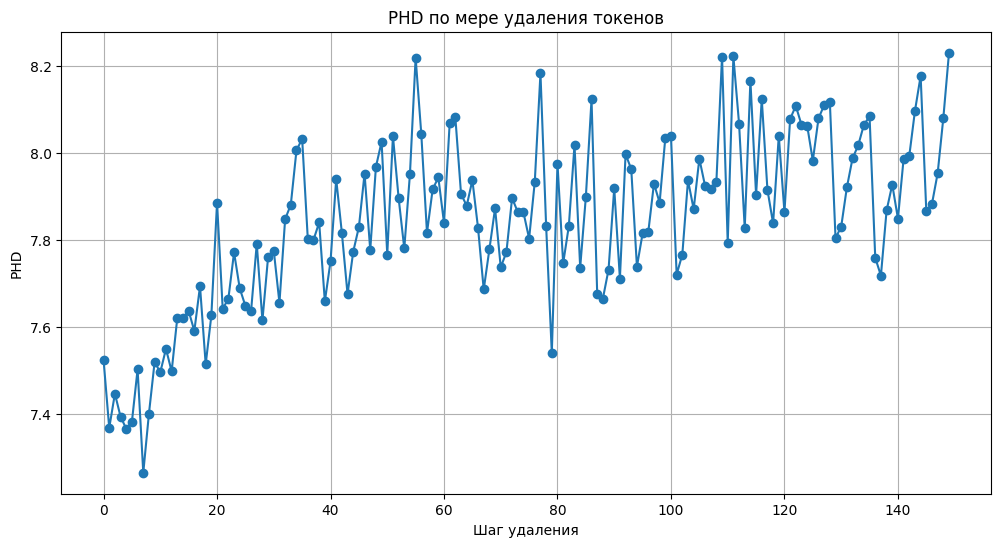

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(phd_curve, marker='o')
plt.title("PHD по мере удаления токенов")
plt.xlabel("Шаг удаления")
plt.ylabel("PHD")
plt.grid(True)
plt.savefig("phd_by_step.png", dpi=300)
plt.show()

Частоты POS:
removed_pos
PROPN    83
PUNCT    21
NUM      21
NOUN     13
VERB      5
DET       2
ADP       2
X         1
SCONJ     1
PART      1
Name: count, dtype: int64


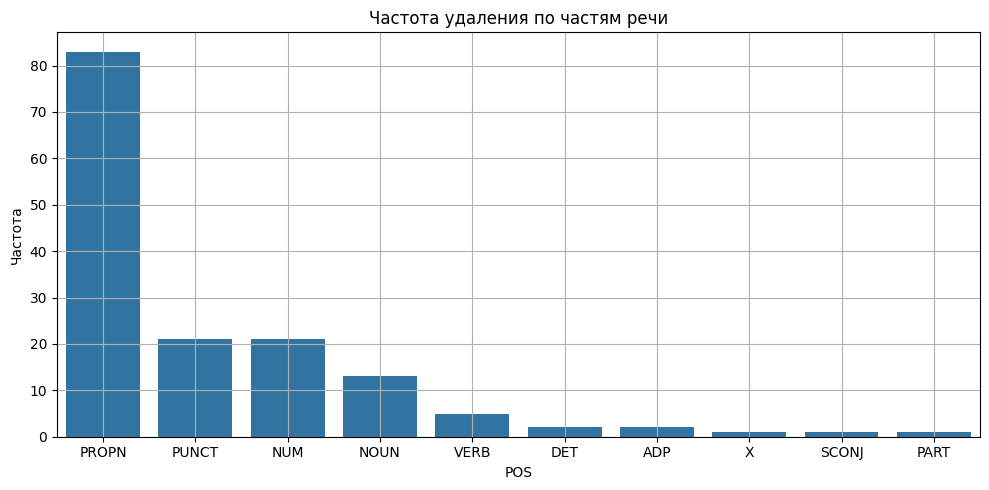

In [14]:
import seaborn as sns

pos_counts = removal_log["removed_pos"].value_counts()
print("Частоты POS:")
print(pos_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=pos_counts.index, y=pos_counts.values)
plt.title("Частота удаления по частям речи")
plt.xlabel("POS")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
propn_tokens = removal_log[removal_log["removed_pos"] == "PROPN"]
print(propn_tokens["removed_token"].value_counts())

removed_token
Ġthe              10
,                  4
ĠSong              3
Ġ                  3
1                  3
9                  3
Ġtheir             3
Ġit                2
ĠContest           2
0                  2
Ġfor               2
2                  2
Ġat                2
ĠEuro              1
4                  1
ĠOctober           1
ĠMalta             1
Ġqualified         1
Ġentry             1
Ġin                1
Ġhad               1
Ġseventeen         1
Ġwinning           1
ĠMal               1
Ġbefore            1
ĠThe               1
ĠPerforming        1
Ġplace             1
tes                1
Ġpublic            1
Ġpoints            1
Ġbroadcaster       1
Ġthat              1
"                  1
Ġsixteen           1
Ġfinal             1
vision             1
co                 1
Ġone               1
Ġperformed         1
Ġcountries         1
Ġparticipation     1
Ġsecond            1
Ġwas               1
Ġposition          1
Ġwith              1
Ġintentions        1

In [5]:
import pandas as pd
import spacy
from transformers import AutoTokenizer

removal_df = pd.read_csv("removed_tokens.csv")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-1.8B")
nlp = spacy.load("en_core_web_sm")

original_text = text
tokens = tokenizer.tokenize(original_text)

for idx in removal_df["removed_idx"]:
    tokens.pop(idx)

final_text = tokenizer.convert_tokens_to_string(tokens)

doc = nlp(final_text)
pos_counts = pd.Series([token.pos_ for token in doc]).value_counts()
print("POS теги, оставшиеся в тексте:")
print(pos_counts)

POS теги, оставшиеся в тексте:
PROPN    52
ADP      46
PUNCT    34
NOUN     33
VERB     28
NUM      20
DET      18
ADJ      13
ADV       8
PRON      8
SCONJ     6
SPACE     5
CCONJ     4
PART      4
AUX       3
Name: count, dtype: int64


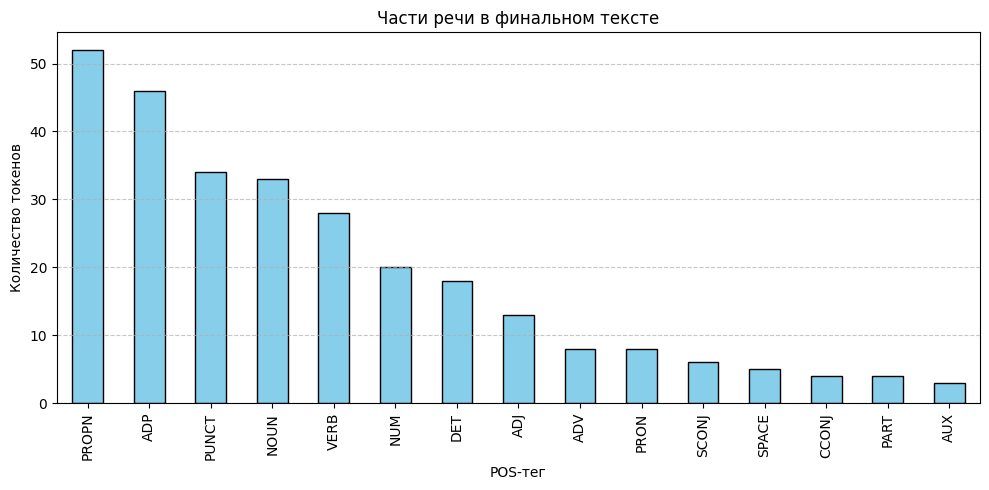

In [6]:
plt.figure(figsize=(10, 5))
pos_counts.sort_values(ascending=False).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Части речи в финальном тексте")
plt.ylabel("Количество токенов")
plt.xlabel("POS-тег")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
from collections import defaultdict

# Группируем слова по частям речи
pos_to_words = defaultdict(list)
for token in doc:
    pos_to_words[token.pos_].append(token.text)

# Сортируем по убыванию количества слов в каждой группе
sorted_pos = sorted(pos_to_words.items(), key=lambda x: len(x[1]), reverse=True)

print("\nСлова, сгруппированные по частям речи:\n")
for pos, words in sorted_pos:
    unique_words = list(dict.fromkeys(words))  # сохранить порядок, убрать повторы
    print(f"{pos} ({len(unique_words)}):")
    print(", ".join(unique_words[:30]), end="")  # первые 30 слов
    if len(unique_words) > 30:
        print(", ...")
    else:
        print()


Слова, сгруппированные по частям речи:

PROPN (24):
Malta, Contest, Angel, Chiara, Euro, Song, iniv, Europe, Public, Broadcasting, PBS, February, Chi, Eurovision, BackgroundPrior, Ira, Los, Off, Julie, Ludwig, For205, Services, Mal, Maltese
ADP (16):
in, with, by, for, on, as, after, of, during, out, to, In, On, on1, through, at
PUNCT (6):
", ,, ., (, ), 0
NOUN (24):
thevision, song, edition, entry, contest, competition, %, televote, finishers, show, times, 70s, years, country, point, Wonder, broadcaster, broadcast, selection, nation, final, method, 25Malta, format
VERB (21):
participated, represented, achieved, selected, organised, consisted, held, performed, gaining, compete, placed, participating, competed, withdrawing, had, returning, qualified, placed1th, confirmed, participate, continued
NUM (15):
2005, 198, 1, ten, 3, 4, 192, 1971, 199, 2002, 2004, 20, 200, 2, 0
DET (4):
The, the, a, this
ADJ (7):
ninth, Maltese, national, final, highest, best, second
PRON (7):
who, he, The, it

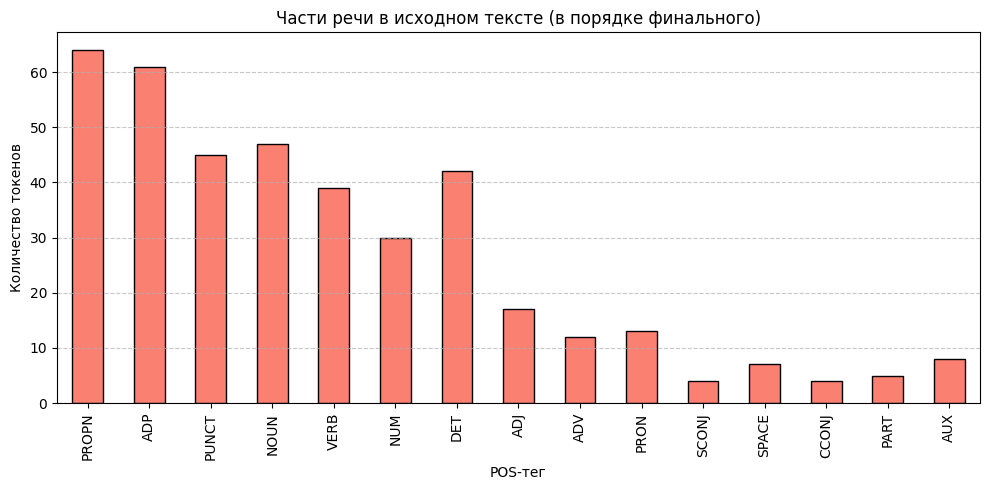

In [ ]:
doc_original = nlp(original_text)
pos_counts_original = pd.Series([token.pos_ for token in doc_original]).value_counts()

pos_order = pos_counts.index.tolist()  # порядок из финального текста
pos_counts_original_sorted = pos_counts_original.reindex(pos_order, fill_value=0)

plt.figure(figsize=(10, 5))
pos_counts_original_sorted.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Части речи в исходном тексте (в порядке финального)")
plt.ylabel("Количество токенов")
plt.xlabel("POS-тег")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Подсчет POS только вначале

In [7]:
class IDReducer:
    def __init__(self, text, model, tokenizer, max_workers=8):
        self.original_text = text
        self.model = model
        self.tokenizer = tokenizer
        self.max_workers = max_workers

        self.tokens = self.tokenizer.tokenize(text)
        self.text = text
        self.phd_by_step = []
        self.removal_log = []
        self.delta_mle_log = []

        self.nlp = spacy.load("en_core_web_sm")  # POS-теги
        self.initial_pos_tags = self.get_pos_tags(self.tokens)  # ← сохраняем один раз

    def get_pos_tags(self, tokens):
        doc = self.nlp(" ".join(tokens))
        return [token.pos_ for token in doc]

    def remove_token(self, tokens, idx):
        return tokens[:idx] + tokens[idx + 1:]

    def compute_deltas(self, tokens, full_mle, step):
        results = []

        def process(idx):
            new_tokens = self.remove_token(tokens, idx)
            text_i = self.tokenizer.convert_tokens_to_string(new_tokens)
            embeds_i = get_embeds(text_i)
            mle_i = mle_estimate_phd(embeds_i)
            delta = abs(full_mle - mle_i)
            return {
                "step": step,
                "token_idx": idx,
                "token_text": tokens[idx],
                "pos_tag": self.initial_pos_tags[idx],  # ← используем фиксированный тег
                "delta_mle": delta
            }

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            results = list(executor.map(process, tqdm(range(len(tokens)))))

        return results

    def run(self, max_steps=None):
        tokens = self.tokens.copy()
        current_text = self.text

        # Эмбеддинги полного текста
        embeds_full = get_embeds(current_text)
        full_mle = mle_estimate_phd(embeds_full)

        # Первый PHD
        current_id = compute_phd(current_text, self.model, self.tokenizer)

        step = 0
        while len(tokens) > 1 and (max_steps is None or step < max_steps):
            print(f"Step: {step}")

            delta_entries = self.compute_deltas(tokens, full_mle, step)
            self.delta_mle_log.extend(delta_entries)

            best = min(delta_entries, key=lambda x: x["delta_mle"])
            idx = best["token_idx"]

            # Удаляем токен
            removed_token = tokens[idx]
            removed_pos = self.initial_pos_tags[idx]  # ← фиксированный тег
            tokens = self.remove_token(tokens, idx)
            current_text = self.tokenizer.convert_tokens_to_string(tokens)

            new_id = compute_phd(current_text, self.model, self.tokenizer)
            delta_id = new_id - current_id
            self.phd_by_step.append(current_id)

            self.removal_log.append({
                "step": step,
                "removed_token": removed_token,
                "removed_idx": idx,
                "removed_pos": removed_pos,
                "id_before": current_id,
                "id_after": new_id,
                "delta_id": delta_id,
                "id_change": "up" if delta_id > 0 else "down" if delta_id < 0 else "same"
            })

            current_id = new_id
            step += 1

            # Обновляем полный MLE
            embeds_full = get_embeds(current_text)
            full_mle = mle_estimate_phd(embeds_full)

        return self.phd_by_step, pd.DataFrame(self.removal_log), pd.DataFrame(self.delta_mle_log)


In [ ]:
reducer = IDReducer(text, model, tokenizer, max_workers=1)
phd_curve, removal_log, delta_mle_log = reducer.run(max_steps=150)

In [12]:
removal_log.to_csv("removed_tokens_init.csv", index=False)
delta_mle_log.to_csv("delta_mle_full_init.csv", index=False)

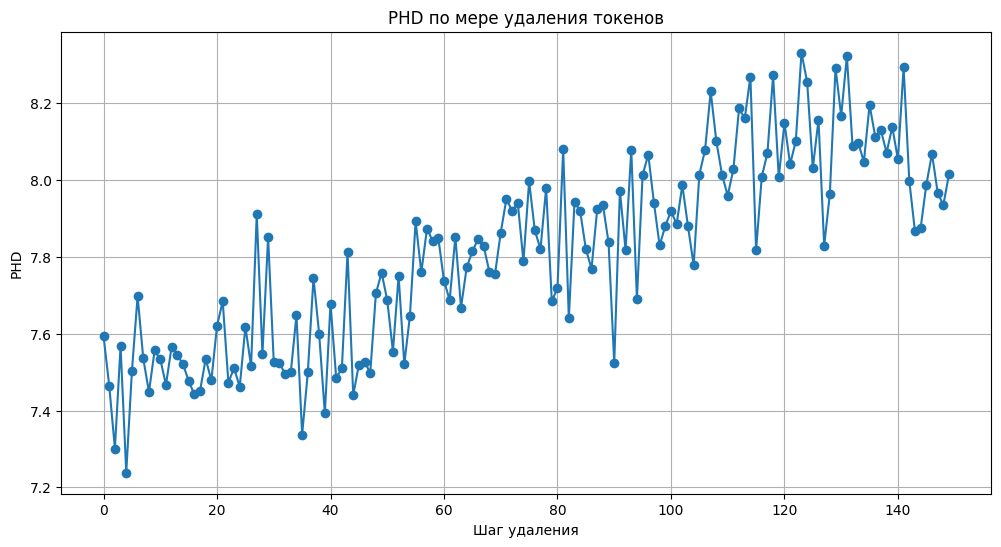

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(phd_curve, marker='o')
plt.title("PHD по мере удаления токенов")
plt.xlabel("Шаг удаления")
plt.ylabel("PHD")
plt.grid(True)
plt.savefig("phd_by_step.png", dpi=300)
plt.show()

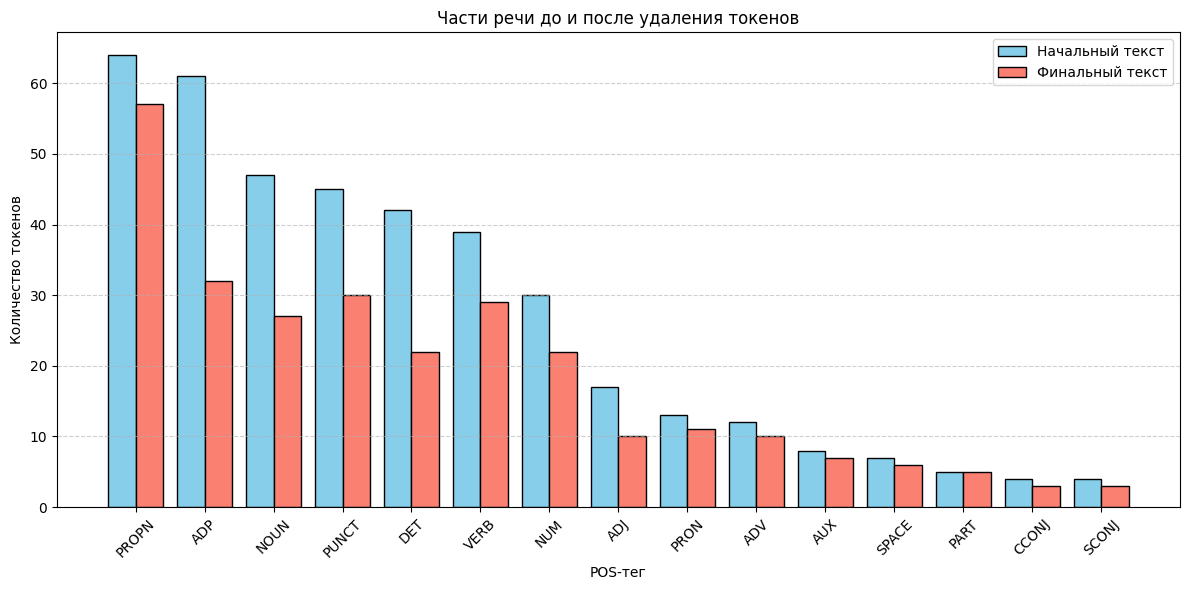

In [16]:
nlp = spacy.load("en_core_web_sm")

original_text = text
tokens = tokenizer.tokenize(original_text)

doc_original = nlp(tokenizer.convert_tokens_to_string(tokens))
pos_original = pd.Series([tok.pos_ for tok in doc_original])
pos_counts_original = pos_original.value_counts()

for idx in sorted(removal_log["removed_idx"], reverse=True):
    tokens.pop(idx)


final_text = tokenizer.convert_tokens_to_string(tokens)
doc_final = nlp(final_text)
pos_final = pd.Series([tok.pos_ for tok in doc_final])
pos_counts_final = pos_final.value_counts()

all_pos = sorted(set(pos_counts_original.index).union(pos_counts_final.index), key=lambda x: pos_counts_original.get(x, 0), reverse=True)
pos_counts_original = pos_counts_original.reindex(all_pos, fill_value=0)
pos_counts_final = pos_counts_final.reindex(all_pos, fill_value=0)

x = range(len(all_pos))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], pos_counts_original.values, width=width, label='Начальный текст', color='skyblue', edgecolor='black')
plt.bar([i + width/2 for i in x], pos_counts_final.values, width=width, label='Финальный текст', color='salmon', edgecolor='black')
plt.xticks(x, all_pos, rotation=45)
plt.xlabel("POS-тег")
plt.ylabel("Количество токенов")
plt.title("Части речи до и после удаления токенов")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

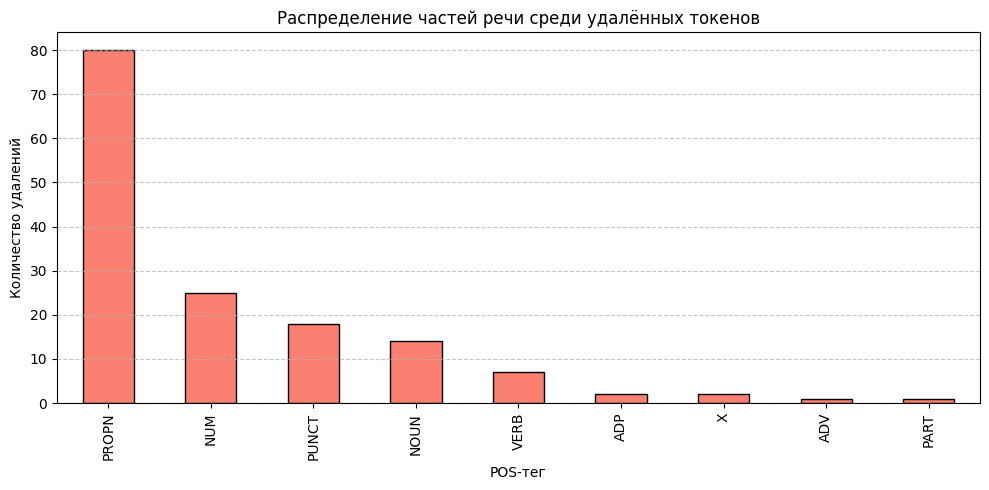

In [17]:
pos_counts_removed = removal_log["removed_pos"].value_counts()

plt.figure(figsize=(10, 5))
pos_counts_removed.sort_values(ascending=False).plot(kind="bar", color="salmon", edgecolor="black")

plt.title("Распределение частей речи среди удалённых токенов")
plt.xlabel("POS-тег")
plt.ylabel("Количество удалений")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

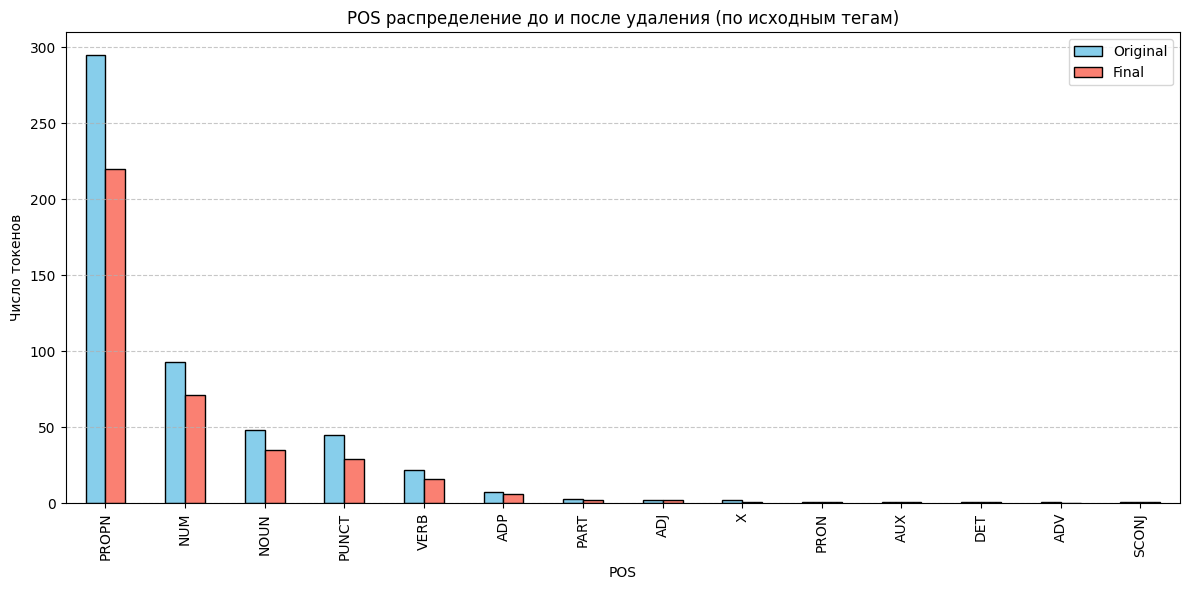

In [22]:
initial_pos_tags = reducer.initial_pos_tags

removed_indices = set(removal_log["removed_idx"])

final_pos_tags = [pos for i, pos in enumerate(initial_pos_tags) if i not in removed_indices]
final_pos_counts = pd.Series(final_pos_tags).value_counts()

# Оригинальные POS
original_pos_counts = pd.Series(initial_pos_tags).value_counts()

# Общий порядок
all_pos = sorted(set(original_pos_counts.index).union(final_pos_counts.index), key=lambda x: -original_pos_counts.get(x, 0))
original_pos_counts = original_pos_counts.reindex(all_pos, fill_value=0)
final_pos_counts = final_pos_counts.reindex(all_pos, fill_value=0)

df = pd.DataFrame({
    "Original": original_pos_counts,
    "Final": final_pos_counts
})

df.plot(kind="bar", figsize=(12, 6), color=["skyblue", "salmon"], edgecolor="black")
plt.title("POS распределение до и после удаления (по исходным тегам)")
plt.ylabel("Число токенов")
plt.xlabel("POS")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
removed_by_pos = removal_log.groupby("removed_pos")["removed_token"].apply(list)

for pos_tag, tokens in removed_by_pos.items():
    print(f"\n{pos_tag} ({len(tokens)} токенов):")
    print(", ".join(tokens))


ADP (2 токенов):
Ġthe, Ġby

ADV (1 токенов):
Ġof

NOUN (14 токенов):
e, Ġit, ,, PBS, 1, e, 2, Ġtheir, Ġposition, Ġnational, ., Ġ, 0, ĠMalta

NUM (25 токенов):
Ġthe, ĠLudwig, ĠMalta, vision, ta, Ġwithdrawing, ĠUkraine, Ġduring, ,, vision, Ġthrough, Ġthe, Ġcompeted, ĠBroadcasting, Ġfor, ", Ġplace, 1, Ġon, PBS, Ġselect, ĠEuro, Ġto, ĠContest, Ġat

PART (1 токенов):
Ġthe

PROPN (80 токенов):
Ġseventeen, 4, Ġsince, Ġin, Ġand, Ġcompetition, vision, ĠSong, Ġhe, 1, Ġthat, Ġwas, 1, Ġconfirmed, Ġat, ĠMalta, 9, Ġwas, 5, Ġthe, ers, Ġnational, 7, 5, 9, ĠContest, ĊĊ, tes, ĠThe, Before, ĠThat, Ġwithin, Ġnation, Ġin, Ġin, ĠSong, Ġfinal, 1, Ġpreviously, vision, 1, co, Ġparticipate, Ġsecond, Prior, ., Ġthe, ĠOne, ĠContest, Ġthe, ĠPublic, 's, Ġyears, Ġcontinued, Ġmethod, Ġthe, Ġwhich, ĠOctober, 7, Ġ, Ġthe, ., 2, 2, Ġperformed, Ġthrough, Ġfirst, Ġthe, Ġorganised, Ġthe, Ġthe, 2, ,, Ġninth, Ġ, Ġa, Ġachieved, 2, 2, 3

PUNCT (18 токенов):
ĠSong, Ġwinning, ĠEurope, Ġit, 1, Ġcompetition, Ġ, 4, 9, 0, e, Mal, Ġti